In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, roc_curve
from sklearn.preprocessing import scale
import torch
import torch.nn as nn
from torch.optim import Adam

In [ ]:

# File ID from the Google Drive link
file_id = '19-2OGM6znP4Bdn8q6tMGIoytfAShetS1'

# Construct the download URL
download_url = f'https://drive.google.com/uc?id={file_id}'

# Load the CSV file into a pandas DataFrame
try:
    data = pd.read_csv(download_url)
    print("Data loaded successfully!")
    print("Columns in the dataset:", data.columns)
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded successfully!
Columns in the dataset: Index(['ts_event', 'bid_fill', 'ask_fill', 'Signed Volume', 'price',
       'best_bid', 'best_ask', 'mid_price'],
      dtype='object')


In [ ]:
data


,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035
...,...,...,...,...,...,...,...,...
27702,2024-10-22 23:58:59,32.0,0.0,32.0,235.54,235.54,235.81,235.675
27703,2024-10-22 23:59:00,40.0,40.0,0.0,235.54,235.23,235.81,235.520
27704,2024-10-22 23:59:37,0.0,1.0,-1.0,235.70,235.23,235.70,235.465
27705,2024-10-22 23:59:41,5.0,0.0,5.0,235.60,235.60,235.70,235.650


In [16]:
# Extract relevant fields
bid_fill = data['bid_fill'].values
ask_fill = data['ask_fill'].values
signed_volume = data['Signed Volume'].values
price = data['price'].values
best_bid = data['best_bid'].values
best_ask = data['best_ask'].values
mid_price = data['mid_price'].values

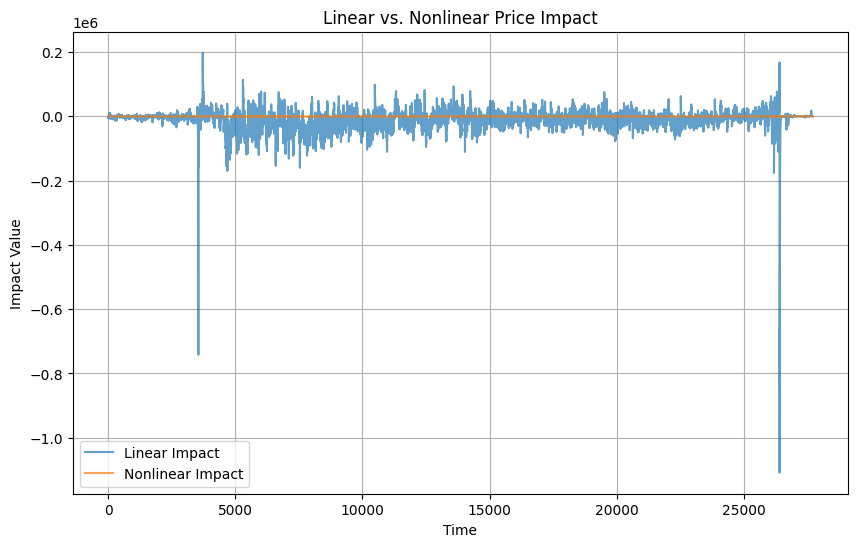

In [17]:
# ================================
# Task 1: Linear and Nonlinear Price Impact Models
# ================================

def compute_price_impact(volume, decay_rate, impact_fn):
    """
    Computes price impact using signed volume and an impact function.

    Parameters:
    - volume: Array of signed volumes.
    - decay_rate: Exponential decay rate.
    - impact_fn: Impact function (linear or nonlinear).

    Returns:
    - impact: Computed price impact.
    """
    impact = []
    cumulative_impact = 0
    for v in volume:
        cumulative_impact = cumulative_impact * np.exp(-decay_rate) + impact_fn(v)
        impact.append(cumulative_impact)
    return np.array(impact)

# Define linear and nonlinear impact functions
linear_impact_fn = lambda x: x
p_value = 0.5  # Concave parameter for nonlinear impact
nonlinear_impact_fn = lambda x: np.sign(x) * abs(x) ** p_value

# Parameters
decay_rate = 0.1

# Compute linear and nonlinear impacts
linear_impact = compute_price_impact(signed_volume, decay_rate, linear_impact_fn)
nonlinear_impact = compute_price_impact(signed_volume, decay_rate, nonlinear_impact_fn)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(linear_impact, label='Linear Impact', alpha=0.7)
plt.plot(nonlinear_impact, label='Nonlinear Impact', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Impact Value')
plt.title('Linear vs. Nonlinear Price Impact')
plt.legend()
plt.grid(True)
plt.show()

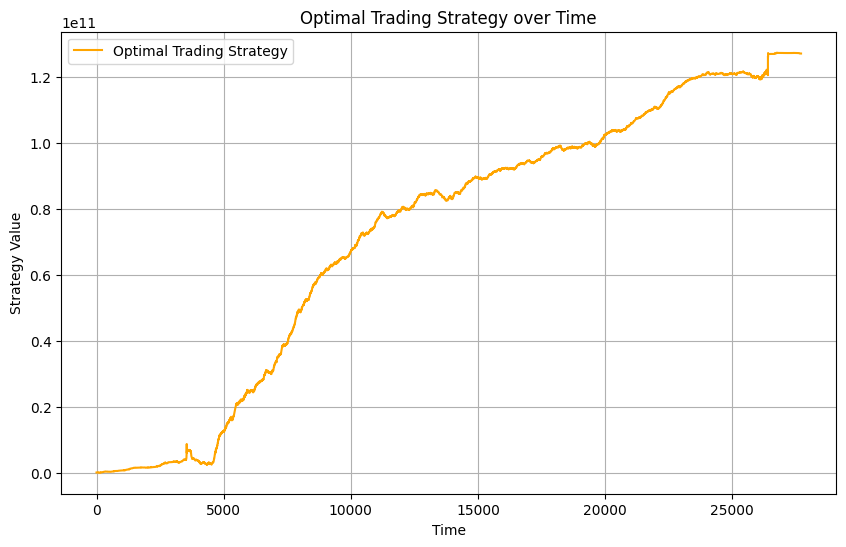

In [18]:
# ====================================
# Task 2: Optimal Linear Trading Strategy
# ====================================

def compute_optimal_strategy(volume, signal, lambda_value, beta, gamma, sigma):
    """
    Computes the optimal trading strategy.

    Parameters:
    - volume: Array of signed trade volumes.
    - signal: Array of trading signals.
    - lambda_value: Impact coefficient.
    - beta: Impact decay rate.
    - gamma: Risk aversion coefficient.
    - sigma: Price volatility.

    Returns:
    - strategy: Optimal trading strategy.
    """
    C_f = (1 + beta / lambda_value) / (gamma * sigma ** 2)
    C_J = 1 / (gamma * sigma ** 2)
    J_t = np.cumsum(volume) * np.exp(-beta)
    strategy = C_f * signal - C_J * J_t
    return strategy

# Parameters for optimal strategy
lambda_value = 0.5
beta = 0.1
gamma = 0.5
sigma = 0.02
trading_signal = np.random.normal(0, 1, len(signed_volume))  # Simulated trading signals

# Compute optimal strategy
optimal_strategy = compute_optimal_strategy(signed_volume, trading_signal, lambda_value, beta, gamma, sigma)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(optimal_strategy, label='Optimal Trading Strategy', color='orange')
plt.xlabel('Time')
plt.ylabel('Strategy Value')
plt.title('Optimal Trading Strategy over Time')
plt.legend()
plt.grid(True)
plt.show()


Epoch 0/100, Loss: 202709.171875
Epoch 10/100, Loss: 156204.21875
Epoch 20/100, Loss: 13107.513671875
Epoch 30/100, Loss: 3652.541748046875
Epoch 40/100, Loss: 2360.080078125
Epoch 50/100, Loss: 50.56378173828125
Epoch 60/100, Loss: 336.8298034667969
Epoch 70/100, Loss: 117.276123046875
Epoch 80/100, Loss: 40.90467071533203
Epoch 90/100, Loss: 12.669711112976074


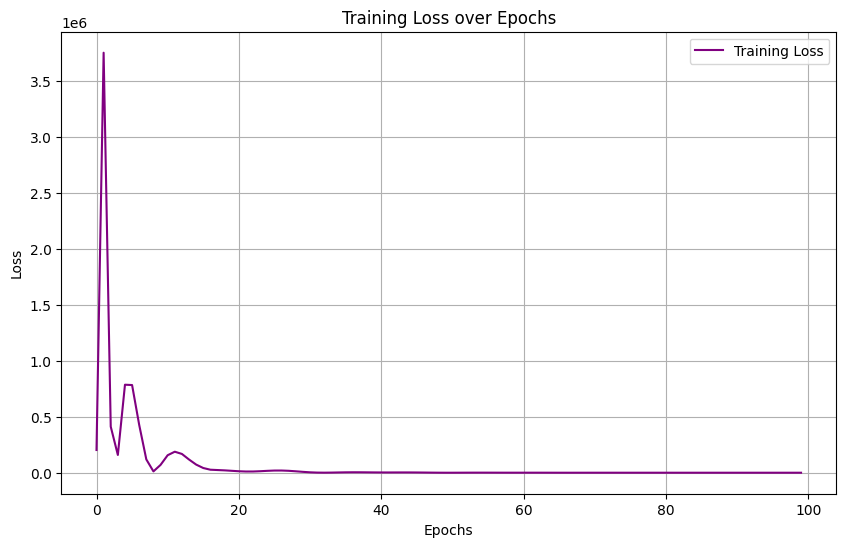

In [19]:
# =============================
# Task 3: Deep Learning Model for Trading
# =============================

class TradingNN(nn.Module):
    """
    Neural network for optimizing trading strategies.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TradingNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

def train_network(data, labels, input_dim, hidden_dim, output_dim, epochs=100, lr=0.01):
    """
    Trains the neural network using provided data.

    Parameters:
    - data: Input data (features).
    - labels: Target labels.
    - input_dim: Number of input features.
    - hidden_dim: Number of hidden units in hidden layers.
    - output_dim: Number of output features.
    - epochs: Number of training epochs.
    - lr: Learning rate for the optimizer.

    Returns:
    - model: Trained neural network.
    - losses: List of training losses.
    """
    model = TradingNN(input_dim, hidden_dim, output_dim)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(data)
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

    return model, losses

# Simulate input data for neural network
np.random.seed(42)
torch.manual_seed(42)
input_dim = 2
hidden_dim = 64
output_dim = 1

# Create torch tensors for training
features = torch.tensor(np.column_stack((signed_volume, mid_price)), dtype=torch.float32)
targets = torch.tensor(np.random.rand(len(signed_volume), output_dim), dtype=torch.float32)

# Train the neural network
model, losses = train_network(features, targets, input_dim, hidden_dim, output_dim)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()